In [1]:
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm

import itertools as it
import time

from ner import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [2]:
#tok_to_id, glv_emb = load_emb('data/glove/glove.6B.100d.txt', int(4e5))
#torch.save((tok_to_id, glv_emb), 'data/pt-cache/tok_to_id__glv_emb.pt')
tok_to_id, glv_emb = torch.load('data/pt-cache/tok_to_id__glv_emb.pt')

In [3]:
#chr_to_id = load_chrs('data/ner-gmb/train.txt')
#torch.save(chr_to_id, 'data/pt-cache/chr_to_id.pt')
chr_to_id = torch.load('data/pt-cache/chr_to_id.pt')

In [4]:
#lbl_to_id, id_to_lbl = load_classes('data/ner-gmb/train.txt')
#torch.save((lbl_to_id, id_to_lbl), 'data/pt-cache/lbl_to_id__id_to_lbl')
lbl_to_id, id_to_lbl = torch.load('data/pt-cache/lbl_to_id__id_to_lbl')

In [5]:
#train_X, train_Y, train_W = load_data('data/ner-gmb/train.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((train_X, train_Y, train_W), 'data/pt-cache/train_X__train_Y__train_W.pt')
train_X, train_Y, train_W = torch.load('data/pt-cache/train_X__train_Y__train_W.pt')

In [6]:
#dev_X, dev_Y, dev_W = load_data('data/ner-gmb/dev.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((dev_X, dev_Y, dev_W), 'data/pt-cache/dev_X__dev_Y__dev_W.pt')
dev_X, dev_Y, dev_W = torch.load('data/pt-cache/dev_X__dev_Y__dev_W.pt')

In [7]:
#test_X, test_Y, test_W = load_data('data/ner-gmb/test.txt', tok_to_id, lbl_to_id, chr_to_id)
#torch.save((test_X, test_Y, test_W), 'data/pt-cache/test_X__test_Y__test_W.pt')
test_X, test_Y, test_W = torch.load('data/pt-cache/test_X__test_Y__test_W.pt')

In [8]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
rand_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=torch.randn(len(tok_to_id), 100),
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=SeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#rand_model.load_state_dict(torch.load('data/pt-cache/rand_model.pt'))

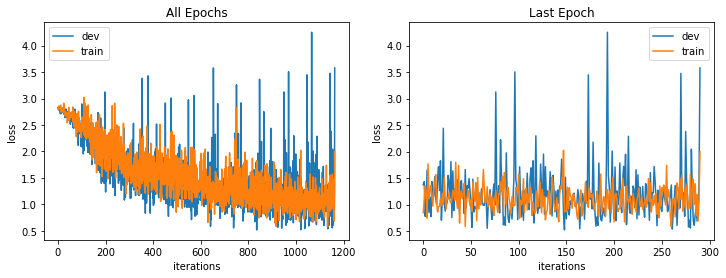

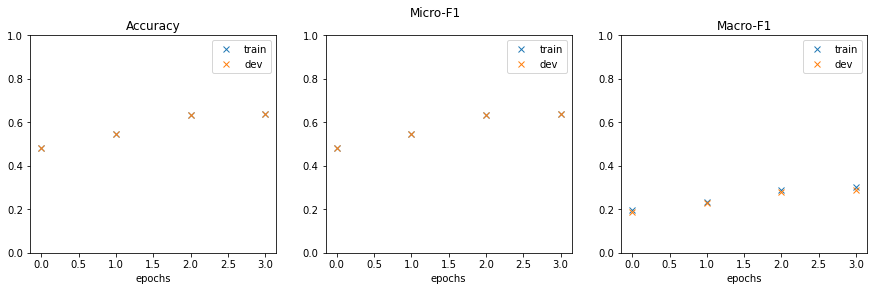

KeyboardInterrupt: 

In [9]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=rand_model.to(device),
    opt=optim.Adam(rand_model.parameters(), lr=0.001),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    grad_clip_norm=5,
    pred_batch_size=4096
)

In [14]:
torch.save(rand_model.state_dict(), 'data/pt-cache/rand_model.pt')

In [25]:
test_pred = rand_tok_model.to(device).batch_predict(test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

              precision    recall  f1-score   support

         art       0.01      0.25      0.02       102
         eve       0.04      0.41      0.07        87
         geo       0.55      0.73      0.63      9912
         gpe       0.78      0.88      0.83      4168
         nat       0.06      0.64      0.11        55
         org       0.13      0.38      0.20      5205
         per       0.42      0.60      0.50      4406
         tim       0.23      0.49      0.31      5275

   micro avg       0.34      0.62      0.44     29210
   macro avg       0.28      0.55      0.33     29210
weighted avg       0.43      0.62      0.50     29210



In [8]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
glv_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=glv_emb,
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=SeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#glv_model.load_state_dict(torch.load('data/pt-cache/glv_model.pt'))

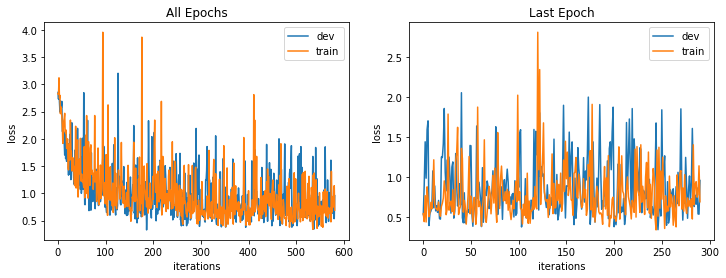

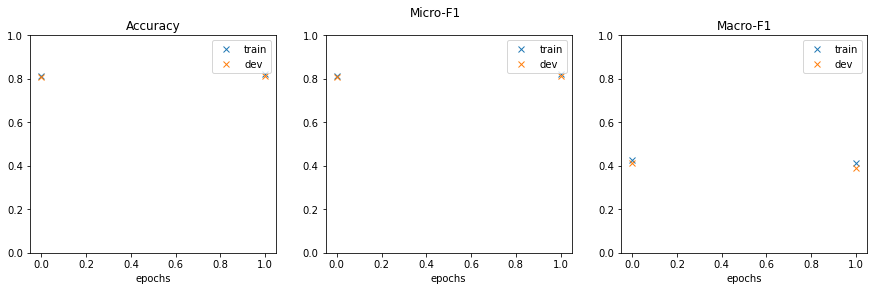

KeyboardInterrupt: 

In [9]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=glv_model.to(device),
    opt=optim.Adam(glv_model.parameters(), lr=0.01),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=4096,
    grad_clip_norm=5
)

In [13]:
torch.save(glv_model.state_dict(), 'data/pt-cache/glv_model.pt')

In [29]:
test_pred = glv_model.to(device).batch_predict(test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

              precision    recall  f1-score   support

         art       0.01      0.21      0.02       102
         eve       0.03      0.33      0.05        87
         geo       0.64      0.78      0.70      9912
         gpe       0.76      0.87      0.81      4168
         nat       0.06      0.60      0.11        55
         org       0.17      0.41      0.24      5205
         per       0.58      0.74      0.65      4406
         tim       0.32      0.55      0.41      5275

   micro avg       0.42      0.67      0.51     29210
   macro avg       0.32      0.56      0.37     29210
weighted avg       0.50      0.67      0.57     29210



In [10]:
chr_glv_model = NERModel(
    embed_model=ChrTokEmbModel(
        chr_emb_model=ChrEmbModel(
            n_embs=len(chr_to_id),
            pad_chr_id=chr_to_id['PAD_CHR'],
            emb_size=8,
            hidden_size=25
        ),
        tok_emb_model=nn.Embedding.from_pretrained(
            glv_emb,
            freeze=False,
            padding_idx=tok_to_id['PAD_TOK']
        )
    ),
    seq_tag_model=SeqTagModel(
        input_size=150,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#chr_glv_model.load_state_dict(torch.load('data/pt-cache/chr_glv_model.pt'))

In [14]:
train_loop(
    train_set=(train_W, train_X, train_Y),
    dev_set=(dev_W, dev_X, dev_Y),
    model=chr_glv_model.to(device),
    opt=optim.Adam(chr_glv_model.parameters(), lr=0.001),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=2048,
    grad_clip_norm=5
)

KeyboardInterrupt: 

In [ ]:
### TODO: dropout only in training!!!

In [15]:
torch.save(chr_glv_model.state_dict(), 'data/pt-cache/glv_model.pt')

In [17]:
test_pred = chr_glv_model.to(device).batch_predict(test_W, test_X, 4096)
print(conll_report(test_Y, test_pred, id_to_lbl, lbl_to_id['PAD_LBL']))

              precision    recall  f1-score   support

         art       0.03      0.27      0.05       102
         eve       0.05      0.45      0.10        87
         geo       0.66      0.79      0.72      9912
         gpe       0.84      0.89      0.86      4168
         nat       0.09      0.67      0.16        55
         org       0.24      0.50      0.32      5205
         per       0.57      0.74      0.64      4406
         tim       0.41      0.65      0.50      5275

   micro avg       0.48      0.72      0.58     29210
   macro avg       0.36      0.62      0.42     29210
weighted avg       0.55      0.72      0.61     29210



In [28]:
class LSTMCellLN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        k = torch.sqrt(1/torch.tensor(hidden_size, dtype=torch.float))
        self.Wh = nn.Parameter(torch.empty(4, hidden_size, hidden_size).uniform_(-k, k))
        self.Wx = nn.Parameter(torch.empty(4, input_size, hidden_size).uniform_(-k, k))
        self.b = nn.Parameter(torch.zeros(4, hidden_size))
#         self.lnh = nn.LayerNorm((4,hidden_size))
#         self.lnx = nn.LayerNorm((4,hidden_size))
#         self.lnc = nn.LayerNorm((hidden_size,))
    
    def forward(self, X, HC):
        H, C = HC
        f, i, o, g = (torch.matmul(H,self.Wh).transpose(0,1) \
                      + torch.matmul(X,self.Wx).transpose(0,1) + self.b).transpose(0,1)
        C = torch.sigmoid(f) * C + torch.sigmoid(i) * torch.tanh(g)
        H = torch.sigmoid(o) * torch.tanh(C)
        return H, C

In [76]:
class LSTMCellLN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        k = torch.sqrt(1/torch.tensor(hidden_size, dtype=torch.float))
        self.Wh = nn.Parameter(torch.empty(hidden_size, 3+hidden_size).uniform_(-k, k))
        self.Wx = nn.Parameter(torch.empty(input_size, 3+hidden_size).uniform_(-k, k))
        self.b = nn.Parameter(torch.zeros(3+hidden_size))
        self.lnh = nn.LayerNorm(3+hidden_size)
        self.lnx = nn.LayerNorm(3+hidden_size)
        self.lnc = nn.LayerNorm(hidden_size)
    
    def forward(self, X, HC):
        H, C = HC
        tmp = self.lnh(H@self.Wh) + self.lnx(X@self.Wx) + self.b
        f = tmp[:,[0]]
        i = tmp[:,[1]]
        o = tmp[:,[2]]
        g = tmp[:,3:]
        C = torch.sigmoid(f) * C + torch.sigmoid(i) * torch.tanh(g)
        H = torch.sigmoid(o) * torch.tanh(self.lnc(C))
        return H, C

In [77]:
class LNSeqTagModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        self.hidden_size = hidden_size
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.lstm_cell_f = nn.LSTMCell(input_size, hidden_size)
        self.h0_f = nn.Parameter(torch.zeros(hidden_size))
        self.c0_f = nn.Parameter(torch.zeros(hidden_size))
        self.lstm_cell_b = LSTMCellLN(input_size, hidden_size)
        self.h0_b = nn.Parameter(torch.zeros(hidden_size))
        self.c0_b = nn.Parameter(torch.zeros(hidden_size))
        self.linear = nn.Linear(2*hidden_size, output_size)
    
    def forward(self, X):
        D = self.dropout(X)
        H = torch.empty(X.shape[0], X.shape[1], 2*self.hidden_size, device=X.device)
        
        h = self.h0_f.expand(X.shape[0], -1).contiguous()
        c = self.c0_f.expand(X.shape[0], -1).contiguous()
        for i in range(X.shape[1]):
            h, c = self.lstm_cell_f(D[:,i,:], (h, c))
            H[:,i,:self.hidden_size] = h

        h = self.h0_b.expand(X.shape[0], -1).contiguous()
        c = self.c0_b.expand(X.shape[0], -1).contiguous()
        for i in range(X.shape[1]-1,-1,-1):
            h, c = self.lstm_cell_b(D[:,i,:], (h, c))
            H[:,i,-self.hidden_size:] = h

        return self.linear(H)

In [78]:
assert(lbl_to_id['PAD_LBL'] == len(lbl_to_id)-1)
ln_glv_model = NERModel(
    embed_model=TokEmbModel(
        init_emb=glv_emb,
        pad_tok_id=tok_to_id['PAD_TOK']
    ),
    seq_tag_model=LNSeqTagModel(
        input_size=100,
        hidden_size=100,
        output_size=len(lbl_to_id)-1,
        dropout_prob=0.5
    ),
    pad_lbl_id=lbl_to_id['PAD_LBL'],
    pad_tok_id=tok_to_id['PAD_TOK'],
    class_freq=torch.bincount(train_Y.reshape(-1))[:-1]
)
#glv_model.load_state_dict(torch.load('data/pt-cache/ln_glv_model.pt'))

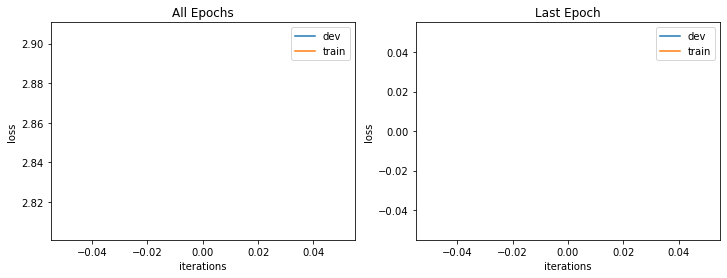

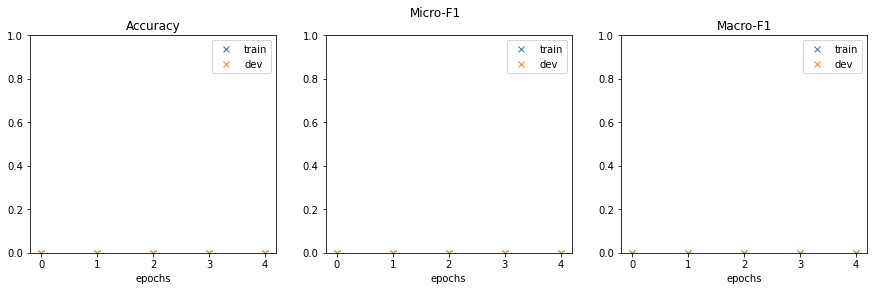

nan
nan


KeyboardInterrupt: 

In [79]:
train_loop(
    train_set=(train_W[:1000], train_X[:1000], train_Y[:1000]),
    dev_set=(dev_W, dev_X, dev_Y),
    model=ln_glv_model.to(device),
    opt=optim.Adam(ln_glv_model.parameters(), lr=0.01),
    n_classes=len(lbl_to_id)-1,
    batch_size=128,
    pred_batch_size=4096,
    grad_clip_norm=5
)